# Setup

In [2]:
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
from matrixlib import preconditioning as precon
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [3]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 1000
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42

VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

In [6]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0.0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=False
    )

In [7]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(f"Matrix Bands Shape: {bands.shape}, Matrix Labels Shape: {labels.shape}")

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

# Create test matrices and labels
test_matrices = test_data.matrices[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Verify Shape
print(f"Test Matrices Shape: {test_matrices.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Matrix Bands Shape: (1000, 21, 64, 1), Matrix Labels Shape: (1000, 64)
Test Matrices Shape: (100, 64, 64), Test Labels Shape: (100, 64)
Train size: 800, Val size: 100, Test size: 100


# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



In [8]:
importlib.reload(precon)

A = np.array([precon.prepare_matrix(test_matrices[i], method='flip') for i in range(test_matrices.shape[0])])
A_minmax = np.array([precon.prepare_matrix(test_matrices[i], method='minmax') for i in range(test_matrices.shape[0])])
precs = precon.block_jacobi_preconditioner_from_predictions(test_matrices, test_labels)
b = np.ones((A.shape[0], A.shape[1]))

# Check Condition Numbers
print(f"Condition number original: {cond(test_matrices[0])}")
print(f"Condition number prepared flipped: {cond(A[0])}")
print(f"Condition number prepared minmax: {cond(A_minmax[0])}")
print(f"Condition number preconditioner: {cond(precs[0])}")
print(f"Condition number Product: {cond(np.matmul(A[0], precs[0]))}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[0] - np.linalg.inv(A[0]))}")

Matrix is singular, using pseudo-inverse for block 23 at indices 61:64
Matrix is singular, using pseudo-inverse for block 26 at indices 60:64
Matrix is singular, using pseudo-inverse for block 27 at indices 61:64
Matrix is singular, using pseudo-inverse for block 28 at indices 60:64
Matrix is singular, using pseudo-inverse for block 29 at indices 62:64
Matrix is singular, using pseudo-inverse for block 58 at indices 61:64
Matrix is singular, using pseudo-inverse for block 63 at indices 37:39
Matrix is singular, using pseudo-inverse for block 70 at indices 62:64
Matrix is singular, using pseudo-inverse for block 71 at indices 60:64
Matrix is singular, using pseudo-inverse for block 78 at indices 10:12
Matrix is singular, using pseudo-inverse for block 81 at indices 61:64
Condition number original: 267.3004150390625
Condition number prepared flipped: 6509.30029296875
Condition number prepared minmax: 106.70255279541016
Condition number preconditioner: 131.39651489257812
Condition number 

(100, 64, 64)
Condition number of matrix 0: 267.3004150390625
Condition number of matrix 1: 809.5377807617188
Condition number of matrix 2: 1895.7469482421875
Condition number of matrix 3: 1271.87841796875
Condition number of matrix 4: 147.76275634765625
Condition number of matrix 5: 528.1627807617188
Condition number of matrix 6: 679.7461547851562
Condition number of matrix 7: 456.88330078125
Condition number of matrix 8: 380.3627014160156
Condition number of matrix 9: 264.9125061035156
Condition number of flipped matrix 0: 6509.30029296875
Condition number of flipped matrix 1: 34825.4453125
Condition number of flipped matrix 2: 827.6182250976562
Condition number of flipped matrix 3: 1398.0509033203125
Condition number of flipped matrix 4: 3037.313232421875
Condition number of flipped matrix 5: 13953.8603515625
Condition number of flipped matrix 6: 2102.190673828125
Condition number of flipped matrix 7: 847.89013671875
Condition number of flipped matrix 8: 4669.349609375
Condition num

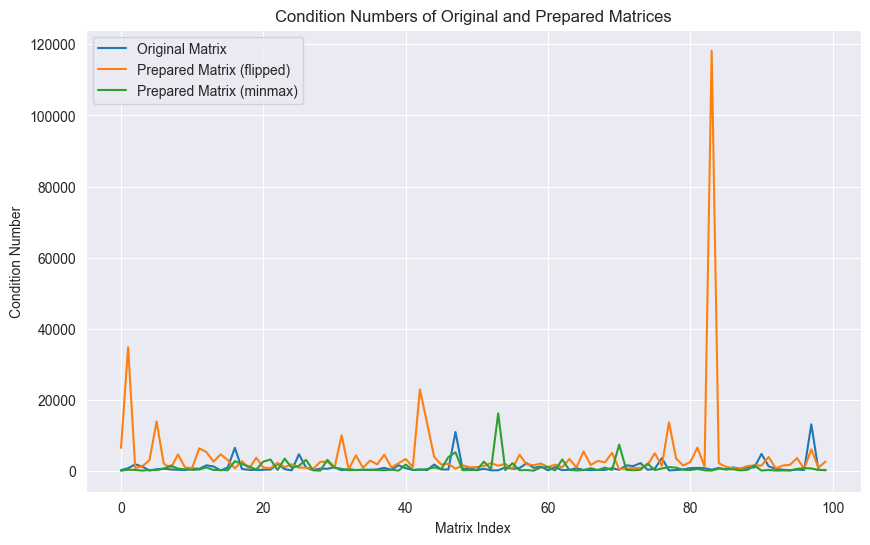

In [9]:
print(test_matrices.shape)
# print(binary_predictions.shape)

for i in range(min(10, test_matrices.shape[0])):
    print(f"Condition number of matrix {i}: {np.linalg.cond(test_matrices[i])}")

for i in range(min(10, A.shape[0])):
    print(f"Condition number of flipped matrix {i}: {np.linalg.cond(A[i])}")

for i in range(min(10, precs.shape[0])):
    print(f"Condition number of minmax matrix {i}: {np.linalg.cond(A_minmax[i])}")
    
# plot condition numbers 
plt.figure(figsize=(10, 6))
plt.plot([np.linalg.cond(test_matrices[i]) for i in range(test_matrices.shape[0])], label='Original Matrix')
plt.plot([np.linalg.cond(A[i]) for i in range(A.shape[0])], label='Prepared Matrix (flipped)')
plt.plot([np.linalg.cond(A_minmax[i]) for i in range(A_minmax.shape[0])], label='Prepared Matrix (minmax)')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()

# Run GMRES Solver with and without Preconditioner

In [12]:
importlib.reload(precon)

# Solve with and without preconditioner
print("Running GMRES for raw test matrices without preconditioner")
x_no_precon_orig, info_no_precon_orig, iters_no_precon_orig, residuals_no_precon_orig = precon.solve_with_gmres_monitored(A=test_matrices, b=b)
print("Running GMRES for prepared matrices without preconditioner")
x_no_precon_prep, info_no_precon_prep, iters_no_precon_prep, residuals_no_precon_prep = precon.solve_with_gmres_monitored(A=A, b=b)
print("Running GMRES for raw test matrices with preconditioner base on test matrices")
x_precon_prep, info_precon_prep, iters_precon_prep, residuals_precon_prep = precon.solve_with_gmres_monitored(A=A, b=b, M=precs)
print("Running GMRES for prepared matrices with preconditioner base on test matrices")
x_precon_minmax, info_precon_minmax, iters_precon_minmax, residuals_precon_minmax = precon.solve_with_gmres_monitored(A=A_minmax, b=b, M=precs)

# Calculate and print the relative residuals
rel_residuals_no_precon = [np.linalg.norm(b[i] - A[i] @ x_no_precon_prep[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]
rel_residuals_precon = [np.linalg.norm(b[i] - A[i] @ x_precon_prep[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]

print("\nRelative residual:")
print(f"  Without preconditioner: "
      f"min={np.min(rel_residuals_no_precon):.2e}, "
      f"max={np.max(rel_residuals_no_precon):.2e}, "
      f"mean={np.mean(rel_residuals_no_precon):.2e}")
print(f"  With preconditioner: "
      f"min={np.min(rel_residuals_precon):.2e}, "
      f"max={np.max(rel_residuals_precon):.2e}, "
      f"mean={np.mean(rel_residuals_precon):.2e}")

Running GMRES for raw test matrices without preconditioner
Without preconditioner:
  Converged: 91 out of 100
  Average iterations: 3938.96
  iterations: [  630  2899   283 12800   494  7320  3902   575  1011   693  3252  1862
  6664 11067   392  2996 10487  1975   826  1075  1051  1038  8542  5624
   933 12800  3993  1752  2035  1346 12800   358  5617   953  1123  1070
  2227 12499  1906  7699   286  1507  3425  1697 12800  2775   853 12800
  2453  3191   803  1175   771  1440  6374  2730  6327  6638  7758  6363
  1362  3857   427  1073  1833  2259  1029  1003  1238  3276  1222 12800
  3996  2705   461  2288  4682   748   771  1375  4605  4749 10840  1080
 12800  1233  3693  3204 12435  3634 12800  4328  5499  1646  1095  4257
  1155 12800  4297   606]
Running GMRES for prepared matrices without preconditioner
Without preconditioner:
  Converged: 99 out of 100
  Average iterations: 845.95
  iterations: [ 1387   635   521   487   230    67   254    96   110   475   247   678
    66  11

Iteration count statistics:
Original (no preconditioner): {'min': 283, 'max': 12800, 'mean': 3938.96, 'median': 2273.5}
Prepared (no preconditioner): {'min': 54, 'max': 12800, 'mean': 845.95, 'median': 307.5}
Prepared (with preconditioner): {'min': 64, 'max': 12786, 'mean': 1061.87, 'median': 309.5}
Prepared minmax (with preconditioner): {'min': 160, 'max': 12800, 'mean': 2980.94, 'median': 874.0}


C:\Users\T\AppData\Local\Temp\ipykernel_67436\4198358886.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([iters_no_precon_orig, iters_no_precon_prep, iters_precon_prep, iters_precon_minmax],


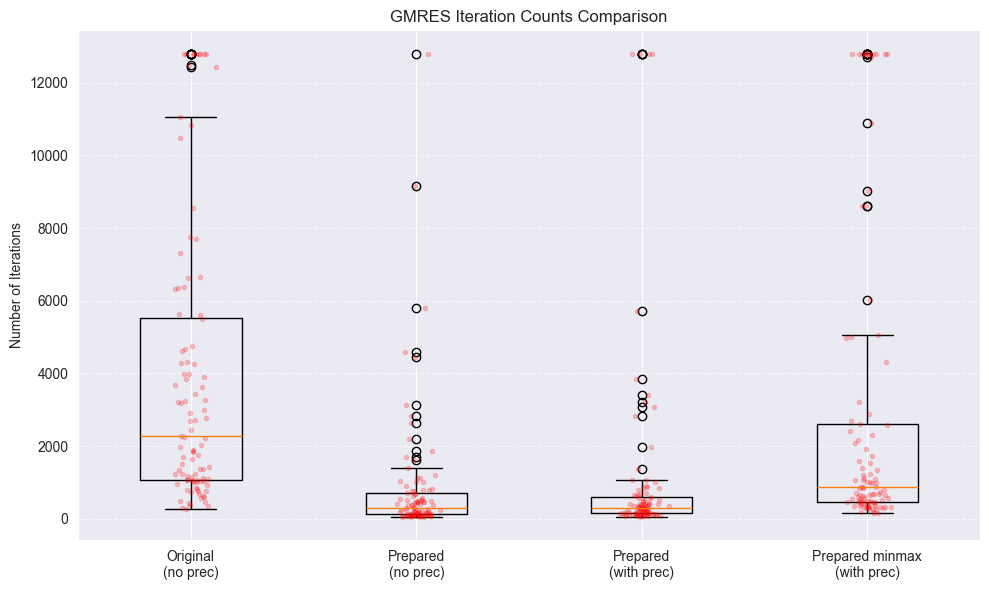

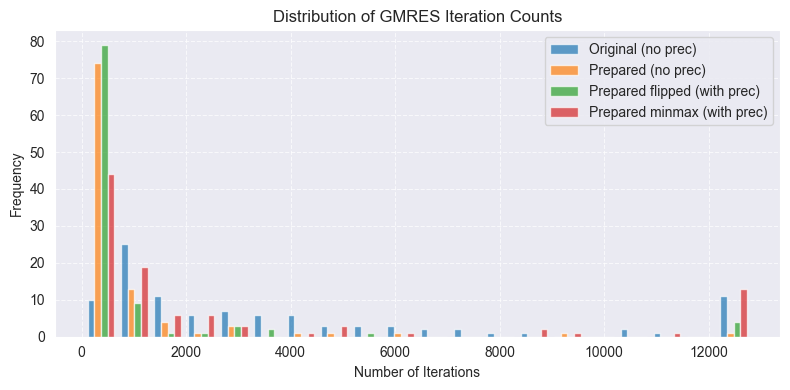

In [13]:
# Calculate statistics for iteration counts
def iter_stats(iters):
    return {
        'min': np.min(iters),
        'max': np.max(iters),
        'mean': np.mean(iters),
        'median': np.median(iters)
    }

# Print statistics
print("Iteration count statistics:")
print(f"Original (no preconditioner): {iter_stats(iters_no_precon_orig)}")
print(f"Prepared (no preconditioner): {iter_stats(iters_no_precon_prep)}")
print(f"Prepared (with preconditioner): {iter_stats(iters_precon_prep)}")
print(f"Prepared minmax (with preconditioner): {iter_stats(iters_precon_minmax)}")

# Create box plots
plt.figure(figsize=(10, 6))
bp = plt.boxplot([iters_no_precon_orig, iters_no_precon_prep, iters_precon_prep, iters_precon_minmax],
                 labels=['Original\n(no prec)', 'Prepared\n(no prec)', 'Prepared\n(with prec)', 'Prepared minmax\n(with prec)'])

plt.title('GMRES Iteration Counts Comparison')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add some jitter to the data points
for i, data in enumerate([iters_no_precon_orig, iters_no_precon_prep, iters_precon_prep, iters_precon_minmax], 1):
    x = np.random.normal(i, 0.04, size=len(data))
    plt.plot(x, data, 'r.', alpha=0.2)

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist([iters_no_precon_orig, iters_no_precon_prep, iters_precon_prep, iters_precon_minmax],
         label=['Original (no prec)', 'Prepared (no prec)', 'Prepared flipped (with prec)', 'Prepared minmax (with prec)'],
         bins=20, alpha=0.7)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of GMRES Iteration Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

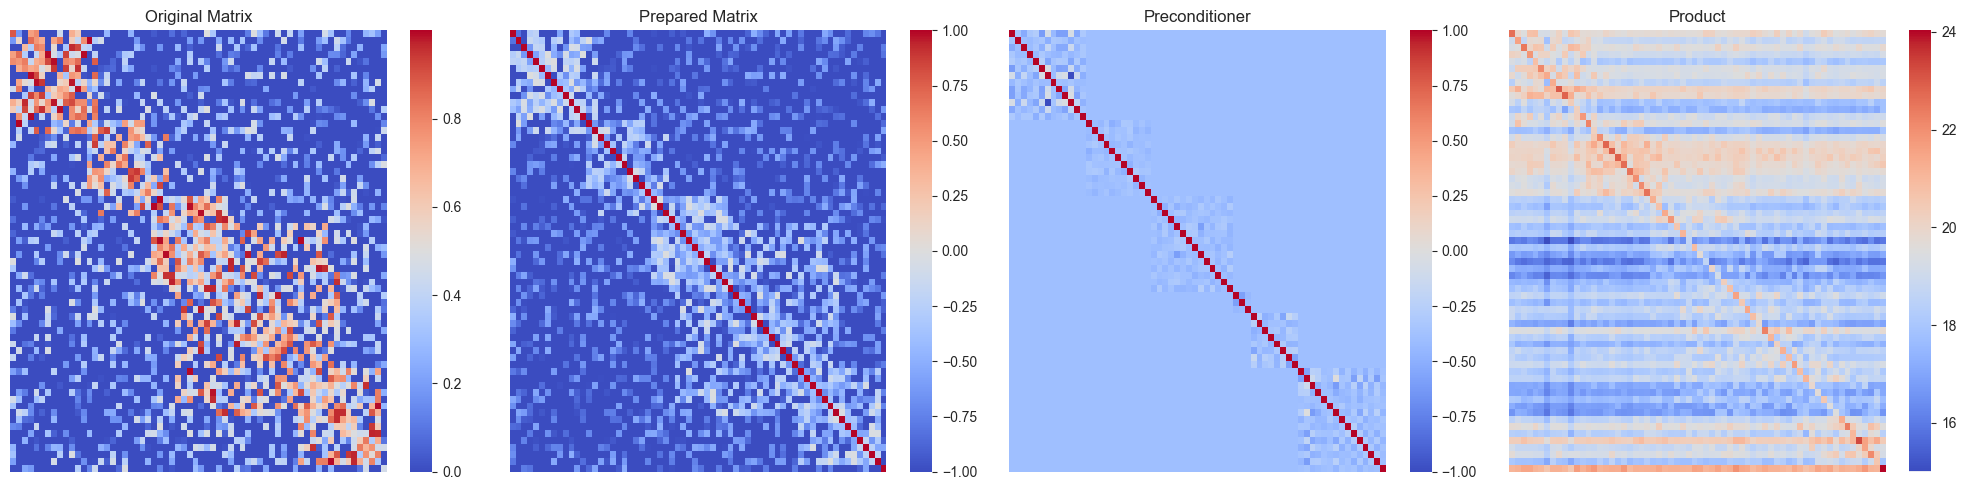

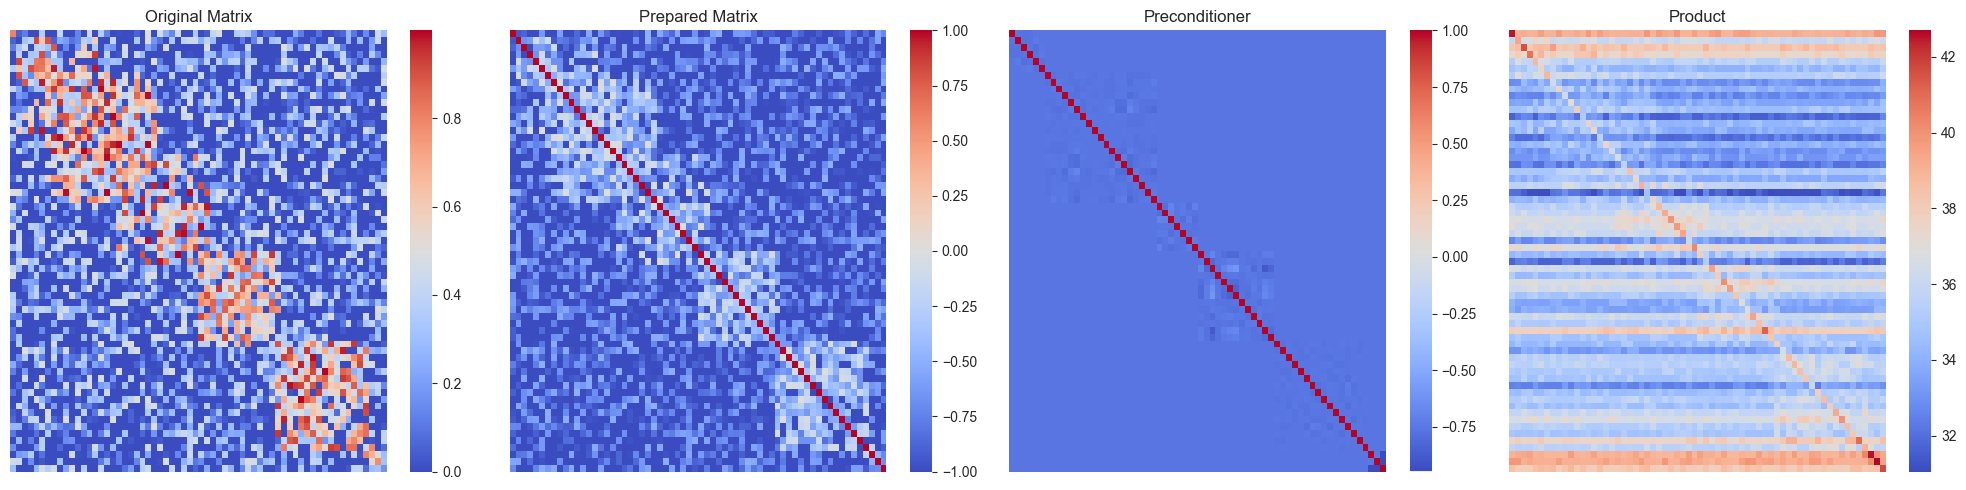

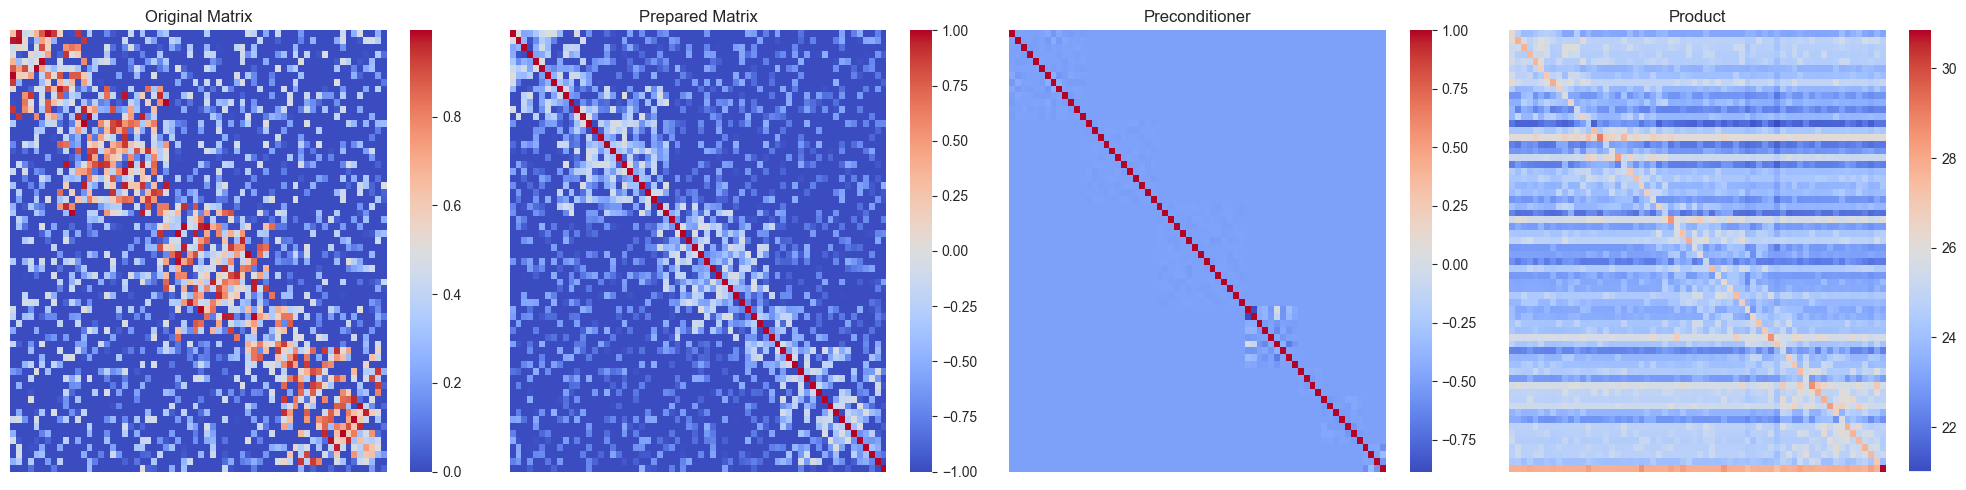

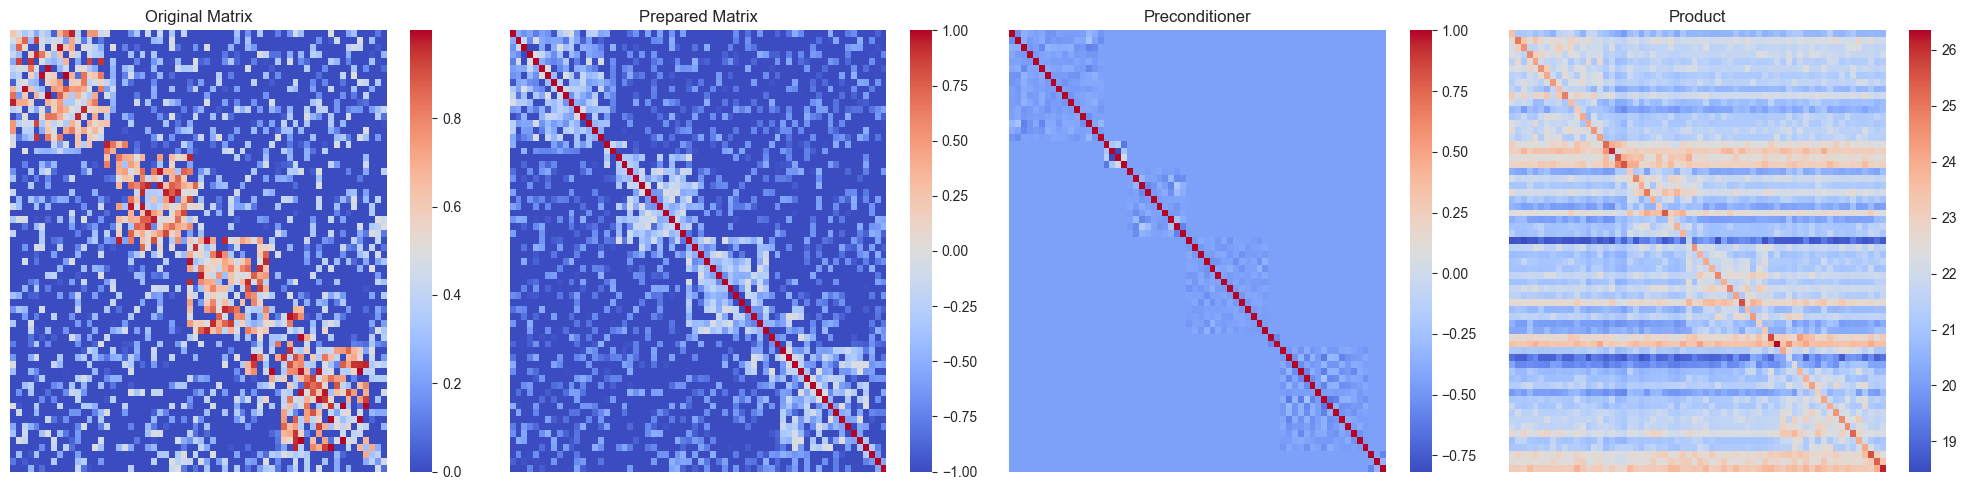

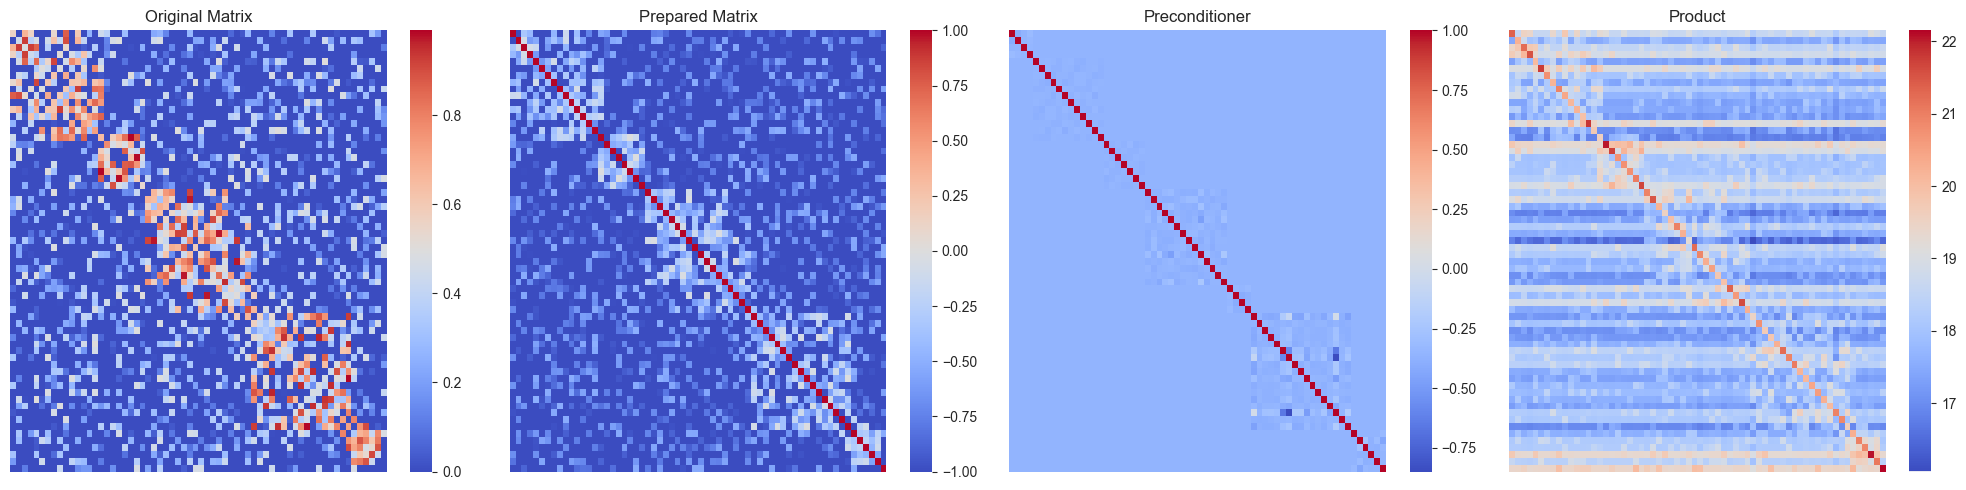

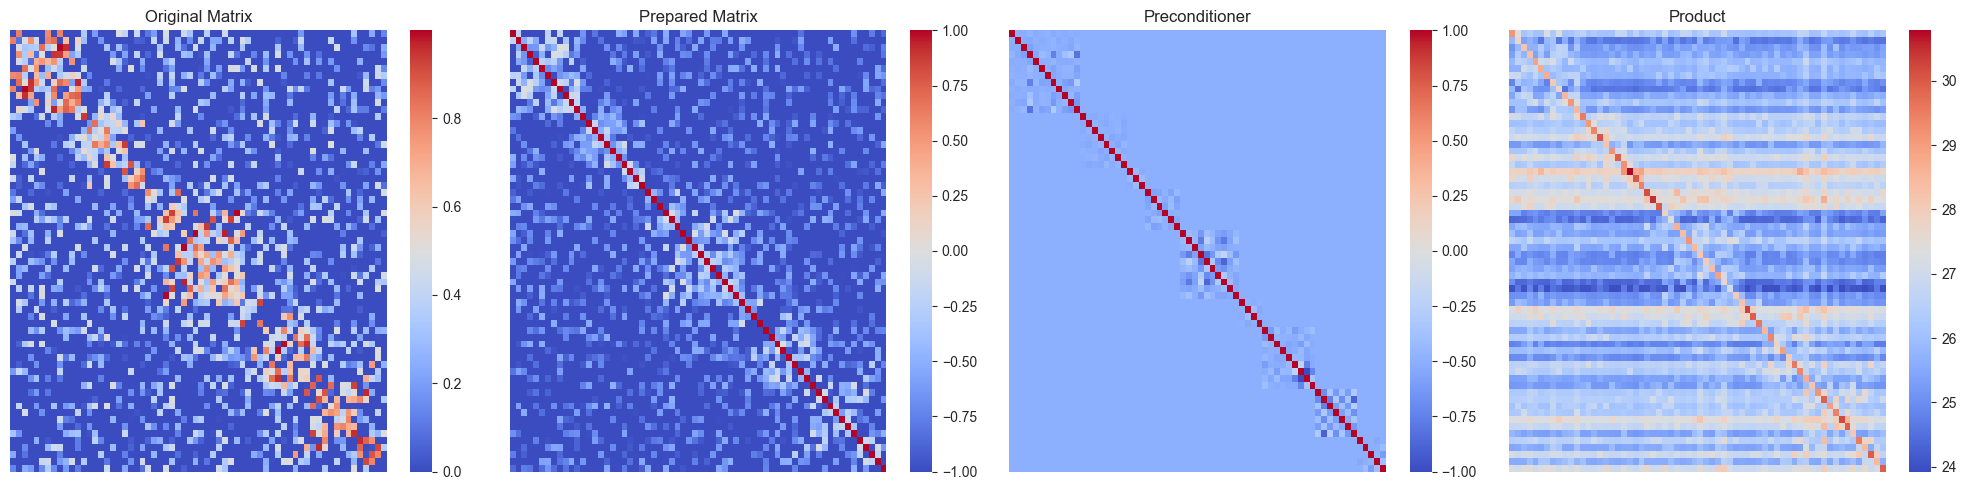

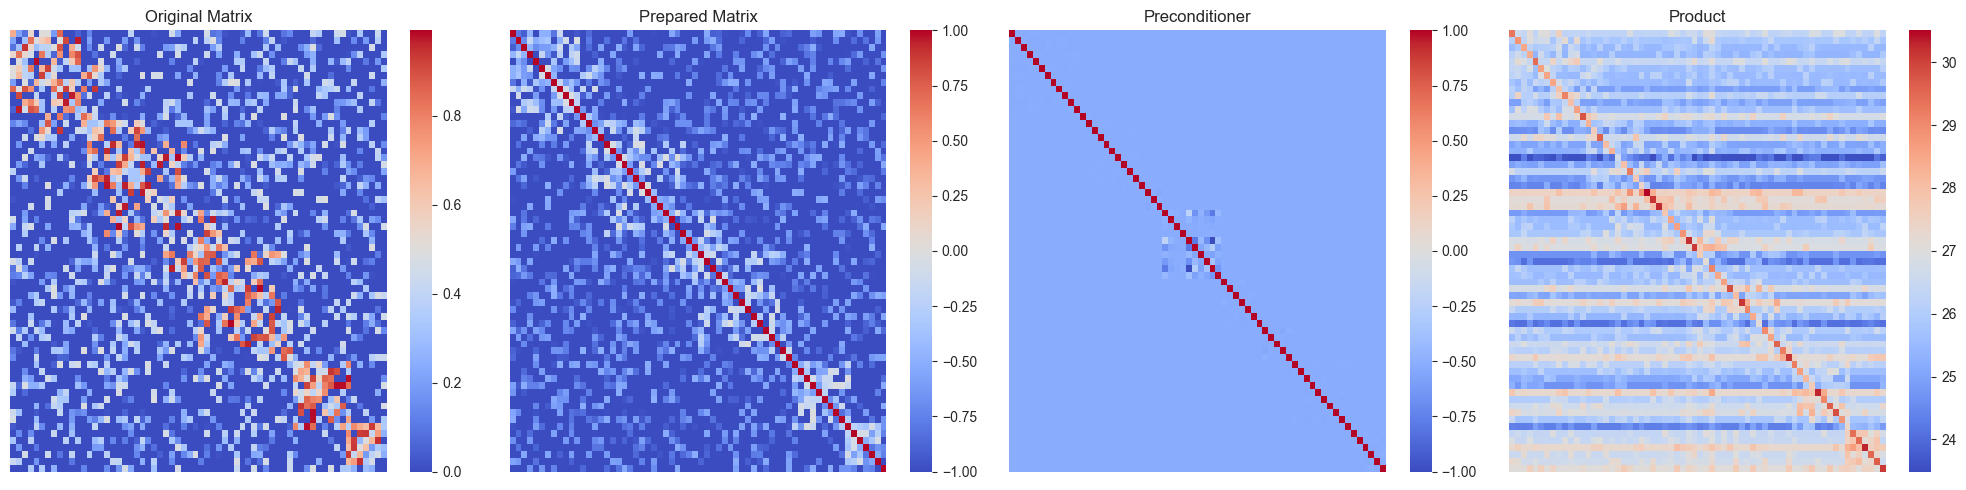

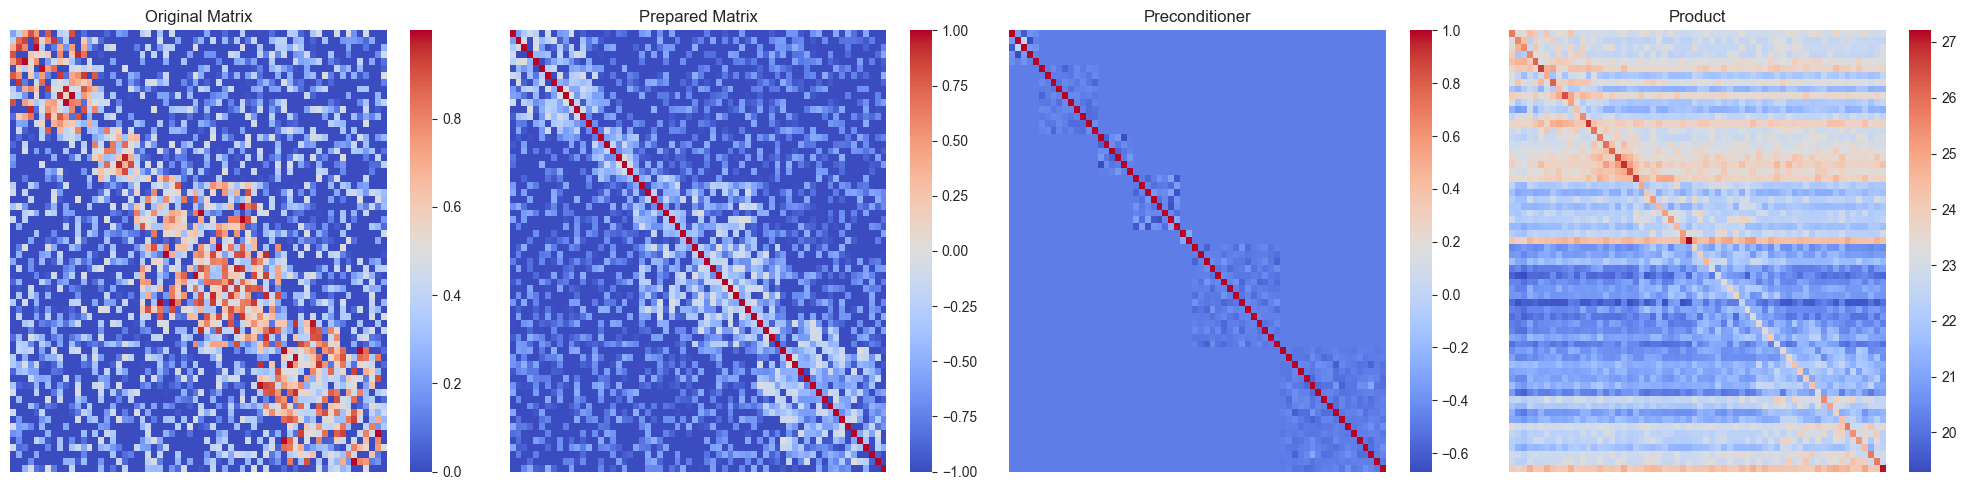

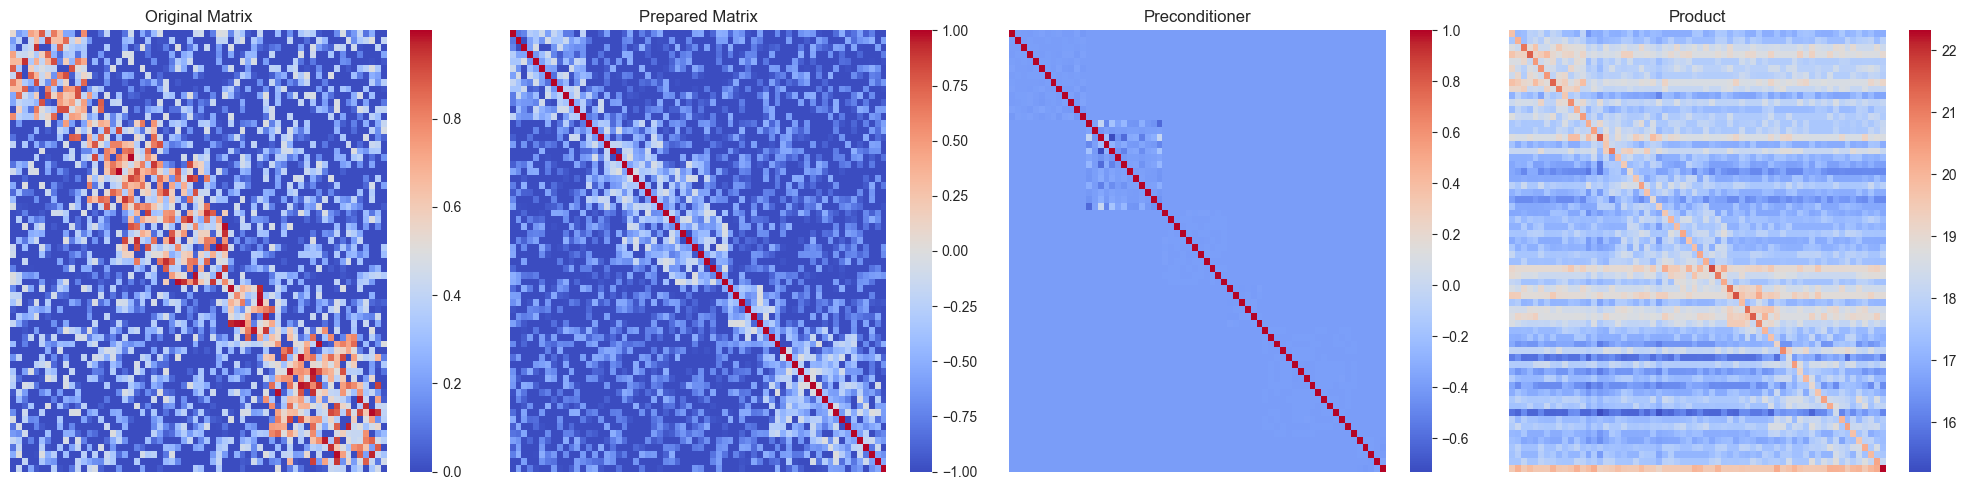

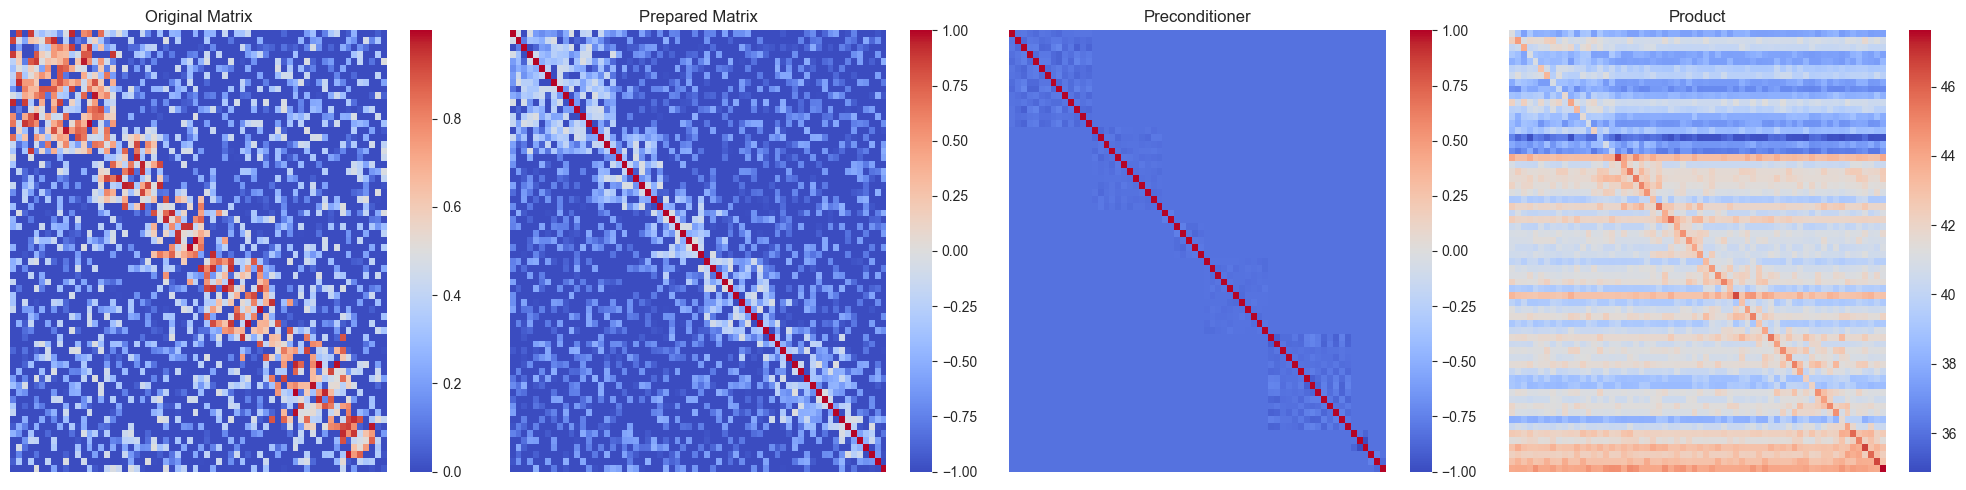

In [14]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
for i in range(10):
    plot_matrices(
        [test_matrices[i], A[i], precs[i], np.matmul(A[i], precs[i])], 
        ['Original Matrix', 'Prepared Matrix', 'Preconditioner', 'Product'], 
        colorbar='coolwarm'
    )

End of notebook.